In [45]:
from minatar import Environment
import numpy as np
import matplotlib.pyplot as plt

# Crear el entorno de MinAtar para el juego Breakout
entorno = Environment("breakout")
num_acciones = entorno.num_actions()
forma_estado = entorno.state_shape()
dim_estado = np.prod(forma_estado)

Episodio 50, Recompensa = 0
Episodio 100, Recompensa = 0
Episodio 150, Recompensa = 0
Episodio 200, Recompensa = 0
Episodio 250, Recompensa = 0
Episodio 300, Recompensa = 0
Episodio 350, Recompensa = 0
Episodio 400, Recompensa = 0
Episodio 450, Recompensa = 0
Episodio 500, Recompensa = 0
Episodio 550, Recompensa = 0
Episodio 600, Recompensa = 0
Episodio 650, Recompensa = 0
Episodio 700, Recompensa = 0
Episodio 750, Recompensa = 0
Episodio 800, Recompensa = 0
Episodio 850, Recompensa = 0
Episodio 900, Recompensa = 0
Episodio 950, Recompensa = 0
Episodio 1000, Recompensa = 0
Episodio 1050, Recompensa = 0
Episodio 1100, Recompensa = 0
Episodio 1150, Recompensa = 0
Episodio 1200, Recompensa = 0
Episodio 1250, Recompensa = 0
Episodio 1300, Recompensa = 0
Episodio 1350, Recompensa = 0
Episodio 1400, Recompensa = 0
Episodio 1450, Recompensa = 0
Episodio 1500, Recompensa = 0
Episodio 1550, Recompensa = 0
Episodio 1600, Recompensa = 0
Episodio 1650, Recompensa = 0
Episodio 1700, Recompensa = 0


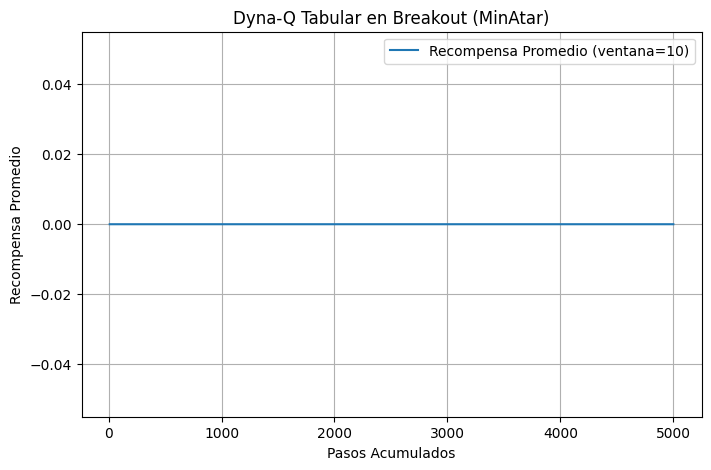


Resultados de la política final en 10 experimentos:
----------------------------------------------
| Métrica      | Valor                |
----------------------------------------------
| Media        | 0.00                 |
| Desviación   | 0.00                 |
----------------------------------------------


In [53]:
from minatar import Environment
import numpy as np
import matplotlib.pyplot as plt
import random

# -------------------------------
# 1. Creación del entorno y parámetros
# -------------------------------
# Crear el entorno Breakout de MinAtar
entorno = Environment("breakout")
num_acciones = entorno.num_actions()
forma_estado = entorno.state_shape()   # Ej.: (10, 10, canales)
dim_estado = np.prod(forma_estado)

# Parámetros del algoritmo Dyna-Q
alpha = 0.1         # Tasa de aprendizaje
gamma = 0.995        # Factor de descuento
epsilon = 0.5       # Parámetro ε para la política ε-greedy
n_planning = 25     # Número de pasos de planeación por paso real
num_episodios = 5000
epsilon = max(0.01, epsilon * 0.99)

# Variables para llevar registro de pasos y recompensas
pasos_totales = 0
lista_pasos = []         # Pasos acumulados al final de cada episodio
lista_recompensas = []   # Recompensa total por episodio

# -------------------------------
# 2. Discretización del estado
# -------------------------------
def obtener_estado(env):
    estado = env.reset()
    if estado is None:
        estado = env.state()
    return estado

def discretizar_estado(estado):
    """
    Convierte el estado (array de MinAtar o valor escalar) en una tupla.
    Esto sirve como clave para la tabla Q y el modelo.
    """
    if isinstance(estado, np.ndarray):
        return tuple(estado.flatten())
    else:
        # Si no es un array (por ejemplo, un int), lo convertimos en tupla de un elemento.
        return (estado,)


# Ejemplo inicial:
estado_cont = obtener_estado(entorno)
estado = discretizar_estado(estado_cont)

# -------------------------------
# 3. Inicialización de la tabla Q y el Modelo
# -------------------------------
# Tabla Q: diccionario con clave: (estado, acción) y valor: Q-valor
Q = {}

def obtener_Q(estado, accion):
    key = (estado, accion)
    if key not in Q:
        Q[key] = 0.0
    return Q[key]

def actualizar_Q(estado, accion, td_error):
    key = (estado, accion)
    if key not in Q:
        Q[key] = 0.0
    Q[key] += alpha * td_error

# Modelo: diccionario que mapea (estado, acción) a (recompensa, siguiente_estado)
Model = {}

# -------------------------------
# 4. Entrenamiento con Dyna-Q
# -------------------------------
for episodio in range(num_episodios):
    estado_cont = obtener_estado(entorno)  # Obtiene el estado inicial
    estado = discretizar_estado(estado_cont)
    terminado = False
    recompensa_total = 0

    while not terminado:
        # Seleccionar acción con política ε-greedy
        if np.random.rand() < epsilon:
            accion = np.random.randint(num_acciones)
        else:
            q_vals = [obtener_Q(estado, a) for a in range(num_acciones)]
            accion = int(np.argmax(q_vals))
        
        # Ejecutar la acción en el entorno (usar act en lugar de step)
        next_state_cont, recompensa = entorno.act(accion)
        # Si el juego termina, el estado es un arreglo de ceros
        terminal = (np.sum(next_state_cont) == 0)
        terminado = terminal
        pasos_totales += 1
        recompensa_total += recompensa

        next_estado = discretizar_estado(next_state_cont)

        # Actualización de Q mediante Q-learning
        best_next_q = max([obtener_Q(next_estado, a) for a in range(num_acciones)])
        td_error = recompensa + gamma * best_next_q - obtener_Q(estado, accion)
        actualizar_Q(estado, accion, td_error)

        # Actualizar el Modelo con la transición observada
        Model[(estado, accion)] = (recompensa, next_estado)

        # Pasos de planeación: se simulan transiciones del modelo
        if len(Model) > 0:
            for _ in range(n_planning):
                key_sim = random.choice(list(Model.keys()))
                r_sim, next_state_sim = Model[key_sim]
                a_sim = key_sim[1]
                best_next_q_sim = max([obtener_Q(next_state_sim, a) for a in range(num_acciones)])
                td_error_sim = r_sim + gamma * best_next_q_sim - obtener_Q(key_sim[0], a_sim)
                actualizar_Q(key_sim[0], a_sim, td_error_sim)
        
        estado = next_estado

    lista_recompensas.append(recompensa_total)
    lista_pasos.append(pasos_totales)
    
    

    if (episodio + 1) % 50 == 0:
        print(f"Episodio {episodio+1}, Recompensa = {recompensa_total}")

#entorno.close()

# -------------------------------
# 5. Gráfica: Recompensa Promedio vs. Pasos
# -------------------------------
def promedio_movil(datos, ventana=10):
    return np.convolve(datos, np.ones(ventana)/ventana, mode='valid')

ventana = 10
recompensas_suavizadas = promedio_movil(lista_recompensas, ventana)
pasos_suavizados = lista_pasos[ventana-1:]  # Alinear con el promedio móvil

plt.figure(figsize=(8,5))
plt.plot(pasos_suavizados, recompensas_suavizadas, label=f"Recompensa Promedio (ventana={ventana})")
plt.xlabel("Pasos Acumulados")
plt.ylabel("Recompensa Promedio")
plt.title("Dyna-Q Tabular en Breakout (MinAtar)")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 6. Evaluación de la Política Final
# -------------------------------
def evaluar_politica(env, Q, n_episodios=10):
    recompensas = []
    for _ in range(n_episodios):
        estado_cont = obtener_estado(env)
        estado = discretizar_estado(estado_cont)
        terminado = False
        recompensa_total = 0
        while not terminado:
            q_vals = [obtener_Q(estado, a) for a in range(num_acciones)]
            accion = int(np.argmax(q_vals))
            next_state_cont, recompensa = env.act(accion)
            terminal = (np.sum(next_state_cont) == 0)
            terminado = terminal
            recompensa_total += recompensa
            estado = discretizar_estado(next_state_cont)
        recompensas.append(recompensa_total)
    return recompensas

env_eval = Environment("breakout")
recompensas_eval = evaluar_politica(env_eval, Q, n_episodios=10)
#env_eval.close()

media_recompensa = np.mean(recompensas_eval)
std_recompensa = np.std(recompensas_eval)

print("\nResultados de la política final en 10 experimentos:")
print("----------------------------------------------")
print(f"| {'Métrica':<12} | {'Valor':<20} |")
print("----------------------------------------------")
print(f"| {'Media':<12} | {media_recompensa:<20.2f} |")
print(f"| {'Desviación':<12} | {std_recompensa:<20.2f} |")
print("----------------------------------------------")



Episodio 50, Recompensa = 0
Episodio 100, Recompensa = 0
Episodio 150, Recompensa = 0
Episodio 200, Recompensa = 0
Episodio 250, Recompensa = 0
Episodio 300, Recompensa = 0
Episodio 350, Recompensa = 0
Episodio 400, Recompensa = 0
Episodio 450, Recompensa = 0
Episodio 500, Recompensa = 0
Episodio 550, Recompensa = 0
Episodio 600, Recompensa = 0
Episodio 650, Recompensa = 0
Episodio 700, Recompensa = 0
Episodio 750, Recompensa = 0
Episodio 800, Recompensa = 0
Episodio 850, Recompensa = 0
Episodio 900, Recompensa = 0
Episodio 950, Recompensa = 0
Episodio 1000, Recompensa = 0
Episodio 1050, Recompensa = 0
Episodio 1100, Recompensa = 0
Episodio 1150, Recompensa = 0
Episodio 1200, Recompensa = 0
Episodio 1250, Recompensa = 0
Episodio 1300, Recompensa = 0
Episodio 1350, Recompensa = 0
Episodio 1400, Recompensa = 0
Episodio 1450, Recompensa = 0
Episodio 1500, Recompensa = 0
Episodio 1550, Recompensa = 0
Episodio 1600, Recompensa = 0
Episodio 1650, Recompensa = 0
Episodio 1700, Recompensa = 0


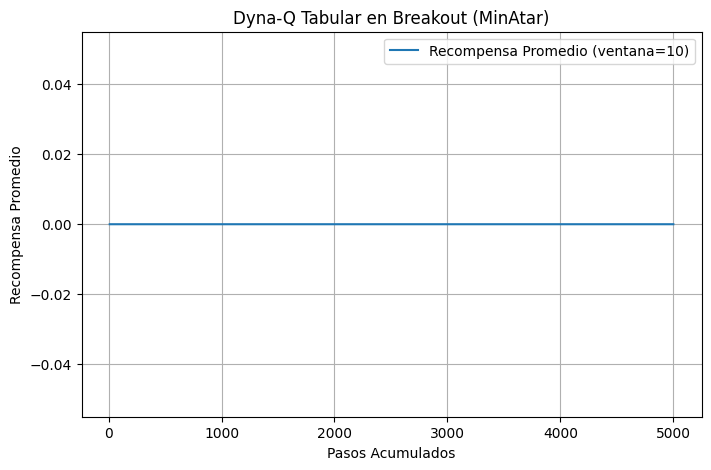


Resultados de la política final en 10 experimentos:
----------------------------------------------
| Métrica      | Valor                |
----------------------------------------------
| Media        | 0.00                 |
| Desviación   | 0.00                 |
----------------------------------------------


In [47]:
from minatar import Environment
import numpy as np
import matplotlib.pyplot as plt
import random

# -------------------------------
# 1. Creación del entorno y parámetros
# -------------------------------
# Crear el entorno Breakout de MinAtar
entorno = Environment("breakout")
num_acciones = entorno.num_actions()
forma_estado = entorno.state_shape()   # Ej.: (10, 10, canales)
dim_estado = np.prod(forma_estado)

# Parámetros del algoritmo Dyna-Q
alpha = 0.1         # Tasa de aprendizaje
gamma = 0.995        # Factor de descuento
epsilon = 0.1       # Parámetro ε para la política ε-greedy
n_planning = 50     # Número de pasos de planeación por paso real
num_episodios = 5000

# Variables para llevar registro de pasos y recompensas
pasos_totales = 0
lista_pasos = []         # Pasos acumulados al final de cada episodio
lista_recompensas = []   # Recompensa total por episodio

# -------------------------------
# 2. Discretización del estado
# -------------------------------
def obtener_estado(env):
    estado = env.reset()
    if estado is None:
        estado = env.state()
    return estado

def discretizar_estado(estado):
    """
    Convierte el estado (array de MinAtar) en una tupla.
    Esto sirve como clave para la tabla Q y el modelo.
    """
    # Si el estado es un array, aplanarlo; si no, convertir a tupla
    if hasattr(estado, 'flatten'):
        return tuple(estado.flatten())
    else:
        return (estado,)

# Ejemplo inicial:
estado_cont = obtener_estado(entorno)
estado = discretizar_estado(estado_cont)

# -------------------------------
# 3. Inicialización de la tabla Q y el Modelo
# -------------------------------
# Tabla Q: diccionario con clave: (estado, acción) y valor: Q-valor
Q = {}

def obtener_Q(estado, accion):
    key = (estado, accion)
    if key not in Q:
        Q[key] = 0.0
    return Q[key]

def actualizar_Q(estado, accion, td_error):
    key = (estado, accion)
    if key not in Q:
        Q[key] = 0.0
    Q[key] += alpha * td_error

# Modelo: diccionario que mapea (estado, acción) a (recompensa, siguiente_estado)
Model = {}

# -------------------------------
# 4. Entrenamiento con Dyna-Q
# -------------------------------
for episodio in range(num_episodios):
    estado_cont = obtener_estado(entorno)  # Obtiene el estado inicial
    estado = discretizar_estado(estado_cont)
    terminado = False
    recompensa_total = 0

    while not terminado:
        # Seleccionar acción con política ε-greedy
        if np.random.rand() < epsilon:
            accion = np.random.randint(num_acciones)
        else:
            q_vals = [obtener_Q(estado, a) for a in range(num_acciones)]
            accion = int(np.argmax(q_vals))
        
        # Ejecutar la acción en el entorno (usar act en lugar de step)
        next_state_cont, recompensa = entorno.act(accion)
        # Se determina si el juego terminó verificando si el estado es todo ceros
        terminal = (np.sum(next_state_cont) == 0)
        terminado = terminal
        pasos_totales += 1
        recompensa_total += recompensa

        next_estado = discretizar_estado(next_state_cont)

        # Actualización de Q mediante Q-learning
        best_next_q = max([obtener_Q(next_estado, a) for a in range(num_acciones)])
        td_error = recompensa + gamma * best_next_q - obtener_Q(estado, accion)
        actualizar_Q(estado, accion, td_error)

        # Actualizar el Modelo con la transición observada
        Model[(estado, accion)] = (recompensa, next_estado)

        # Pasos de planeación: se simulan transiciones del modelo
        if len(Model) > 0:
            for _ in range(n_planning):
                key_sim = random.choice(list(Model.keys()))
                r_sim, next_state_sim = Model[key_sim]
                a_sim = key_sim[1]
                best_next_q_sim = max([obtener_Q(next_state_sim, a) for a in range(num_acciones)])
                td_error_sim = r_sim + gamma * best_next_q_sim - obtener_Q(key_sim[0], a_sim)
                actualizar_Q(key_sim[0], a_sim, td_error_sim)
        
        estado = next_estado

    lista_recompensas.append(recompensa_total)
    lista_pasos.append(pasos_totales)
    
    if (episodio + 1) % 50 == 0:
        print(f"Episodio {episodio+1}, Recompensa = {recompensa_total}")

# -------------------------------
# 5. Gráfica: Recompensa Promedio vs. Pasos
# -------------------------------
def promedio_movil(datos, ventana=10):
    return np.convolve(datos, np.ones(ventana)/ventana, mode='valid')

ventana = 10
recompensas_suavizadas = promedio_movil(lista_recompensas, ventana)
pasos_suavizados = lista_pasos[ventana-1:]  # Alinear con el promedio móvil

plt.figure(figsize=(8,5))
plt.plot(pasos_suavizados, recompensas_suavizadas, label=f"Recompensa Promedio (ventana={ventana})")
plt.xlabel("Pasos Acumulados")
plt.ylabel("Recompensa Promedio")
plt.title("Dyna-Q Tabular en Breakout (MinAtar)")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 6. Evaluación de la Política Final
# -------------------------------
def evaluar_politica(env, Q, n_episodios=10):
    recompensas = []
    for _ in range(n_episodios):
        estado_cont = obtener_estado(env)
        estado = discretizar_estado(estado_cont)
        terminado = False
        recompensa_total = 0
        while not terminado:
            q_vals = [obtener_Q(estado, a) for a in range(num_acciones)]
            accion = int(np.argmax(q_vals))
            next_state_cont, recompensa = env.act(accion)
            terminal = (np.sum(next_state_cont) == 0)
            terminado = terminal
            recompensa_total += recompensa
            estado = discretizar_estado(next_state_cont)
        recompensas.append(recompensa_total)
    return recompensas

env_eval = Environment("breakout")
recompensas_eval = evaluar_politica(env_eval, Q, n_episodios=10)
# No se llama a close() porque Environment de MinAtar no lo define

media_recompensa = np.mean(recompensas_eval)
std_recompensa = np.std(recompensas_eval)

print("\nResultados de la política final en 10 experimentos:")
print("----------------------------------------------")
print(f"| {'Métrica':<12} | {'Valor':<20} |")
print("----------------------------------------------")
print(f"| {'Media':<12} | {media_recompensa:<20.2f} |")
print(f"| {'Desviación':<12} | {std_recompensa:<20.2f} |")
print("----------------------------------------------")
